In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns

import pickle
import igraph

In [178]:
m_graph = pickle.load(open('./data/icwsm_polarization/mention_igraph.pickle', "rb"))
r_graph = pickle.load(open('./data/icwsm_polarization/retweet_igraph.pickle', "rb"))

In [179]:
all_graph = pickle.load(open('./data/icwsm_polarization/all_igraph.pickle', "rb"))

In [180]:
# get edge types
all_graph_etypes = pd.read_csv('./data/icwsm_polarization/all.edgelist', sep='\t', usecols=[2], names=["type"])
all_graph_etypes.head()

,type
0,retweet
1,retweet
2,retweet
3,retweet
4,reply


In [181]:
all_graph_etypes.loc[3].type

'retweet'

In [182]:
r_graph.edge_attributes()

['tags', 'type', 'urls', 'time']

In [183]:
r_graph.get_edgelist()[0:10]

[(12464, 7349),
 (6820, 12569),
 (4336, 15967),
 (16397, 5927),
 (8829, 13851),
 (17673, 5153),
 (5467, 3944),
 (9864, 2813),
 (15781, 5425),
 (1195, 6940)]

In [184]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [185]:
def reverse_igraph_edges(graph):
    edge_attributes = graph.edge_attributes()
    attributes_dict = {attr:r_graph.es[attr] for attr in edge_attributes}
    
    reversed_edges = [tuple(reversed(edge)) for edge  in graph.get_edgelist()]
    
    graph.es.delete()
    
    graph.add_edges(reversed_edges)
    
    for attr in edge_attributes:
        r_graph.es[attr] = attributes_dict[attr]


In [186]:
reverse_igraph_edges(r_graph)

In [187]:
r_graph.get_edgelist()[0:10]

[(7349, 12464),
 (12569, 6820),
 (15967, 4336),
 (5927, 16397),
 (13851, 8829),
 (5153, 17673),
 (3944, 5467),
 (2813, 9864),
 (5425, 15781),
 (6940, 1195)]

In [188]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [189]:
# To re-compute the mention layout, uncomment below

# m_layout = m_graph.layout("large")
# pickle.dump(m_layout, open("mention_layout.pickle", "wb"))

In [190]:
# Load previously saved layout
m_layout = pickle.load(open("objects/mention_layout.pickle", "rb"))

In [191]:
# To re-compute the retweet layout, uncomment below

# r_layout=r_graph.layout("large")
# pickle.dump(r_layout, open("retweet_layout.pickle", "wb"))

In [192]:
r_layout=pickle.load(open("objects/retweet_layout.pickle", "rb"))

In [193]:
m_graph.vs["size"]=4
m_graph.es["arrow_size"]=0.3
m_graph.es["width"]=0.5
m_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
m_graph.vs["color"] = [color_dict[cluster] for cluster in m_graph.vs["cluster"]]
m_out = igraph.plot(m_graph, layout=m_layout)

m_out.save("mention_network.png")

In [194]:
r_graph.vs["size"]=4
r_graph.es["arrow_size"]=0.3
r_graph.es["width"]=0.5
r_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
r_graph.vs["color"] = [color_dict[cluster] for cluster in r_graph.vs["cluster"]]
r_out = igraph.plot(r_graph, layout=r_layout)

r_out.save("retweet_network.png")

In [195]:
def plot_edge_distribution(ax, graph, mode, g_type):
    if (mode=="out" or mode=="in"):
        x = list(range(0, graph.maxdegree(mode=mode) + 1))
        y =[graph.degree(mode=mode).count(i) for i in x]

        ax.loglog(x, y, "k.")
        ax.set_xlabel("number of {}".format(g_type))
        ax.set_ylabel("number of users")

In [196]:
width = 12
height = width / 1.618

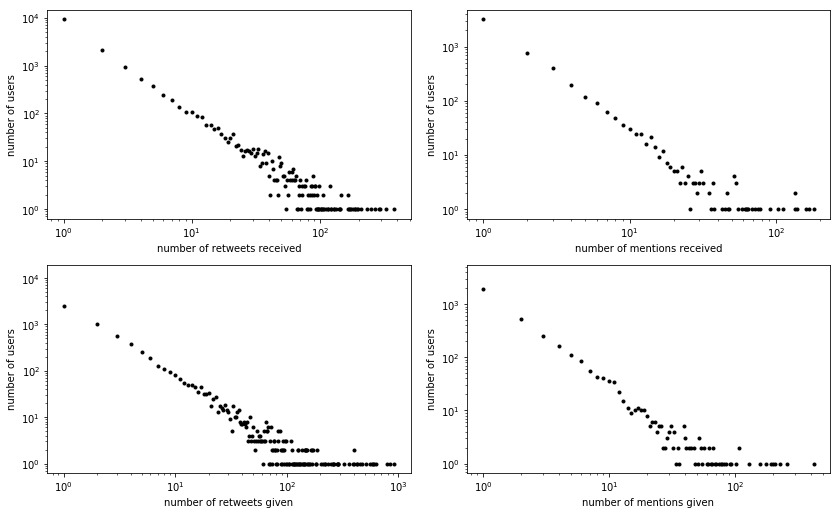

In [197]:
fig, ax = plt.subplots(2,2, figsize=(width, height))
fig.tight_layout(pad=2.5)
plot_edge_distribution(ax[0, 0], r_graph, "out", "retweets received")
plot_edge_distribution(ax[1, 0], r_graph, "in", "retweets given")
plot_edge_distribution(ax[0, 1], m_graph, "out", "mentions received")
plot_edge_distribution(ax[1, 1], m_graph, "in", "mentions given")
fig.savefig("edge_distributions.png", quality=95)

In [198]:
# Build vocabulary vector
# go through all of the edges in the edgelist. If a certain tag is used, then increment the entry in the tag.
# will need a dictionary that maps hashtags to indices in the vocabulary vector
# then going through the entire edgelist again, will need to look at the source (this is the actor)
# and will need to look at the tags associated with that tweet
# then going through each tag, find its appropriate index in the vector, and increment it for that actor


In [199]:
def get_tag_vocab(graph):
    tag2index = {}
    index = 0
    for taglist in graph.es["tags"]:
        for tag in taglist:
            if tag not in tag2index:
                tag2index[tag] = index
                index = index + 1

    return tag2index


In [200]:
vocab = get_tag_vocab(all_graph)

In [201]:
def get_bag_of_tags(graph, etypes, vocab):
    n_nodes = len(graph.vs)
    n_vocab = len(vocab)
    bag_of_tags = np.zeros((n_nodes, n_vocab))

    for i in range(len(graph.get_edgelist())):
        if (etypes.iloc[i].type == 'retweet'):
            node_index = graph.es[i].target
        else:
            node_index = graph.es[i].source
        for tag in graph.es[i]['tags']:
            tag_index = vocab[tag]
            bag_of_tags[node_index][tag_index] += 1
            
    return bag_of_tags

In [202]:
bag_of_tags = get_bag_of_tags(all_graph, all_graph_etypes, vocab)

In [203]:
# put into a pandas and perform PCA
tags_df = pd.DataFrame(data=bag_of_tags, columns=vocab.keys())

In [204]:
tags_df.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
def get_n_most_frequent_tags(df, n):
    tags_count = df.sum(axis=0)
    return tags_count.nlargest(n)

In [206]:
def get_df_n_most_frequent(df, n):
    tags_ntop = get_n_most_frequent_tags(df, n)
    return df.loc[:, tags_ntop.index]

In [207]:
# demonstrate getting most frequent tags
get_n_most_frequent_tags(tags_df, 10)

#tcot        37541.0
#p2          23233.0
#teaparty    12414.0
#gop          7031.0
#tlot         5959.0
#sgp          5889.0
#ocra         4432.0
#dadt         4206.0
#desen        3046.0
#obama        2888.0
dtype: float64

In [208]:
tags_df_topN = get_df_n_most_frequent(tags_df, 20)
tags_df_topN.head()

,#tcot,#p2,#teaparty,#gop,#tlot,#sgp,#ocra,#dadt,#desen,#obama,#twisters,#hhrs,#nvsen,#whyimvotingdemocrat,#dems,#p21,#onenation,#hcr,#votedem,#topprog
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


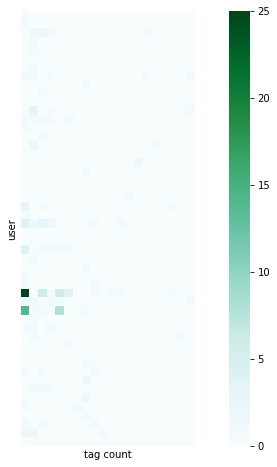

In [209]:
# generate heatmap
sns.heatmap(tags_df_topN.head(50), annot=False, cmap="BuGn", square=True, yticklabels=False, xticklabels=False)
fig = plt.gcf()
figsize=fig.get_size_inches()
fig.set_size_inches(figsize * 2)

plt.ylabel("user")
plt.xlabel("tag count")
fig.savefig("heatmap.png", quality=95)

In [210]:
norm_tags = pd.DataFrame(data=StandardScaler().fit_transform(tags_df), columns=vocab.keys())

In [211]:
norm_tags.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,-0.100115,-0.024906,-0.171627,-0.172866,-0.051653,-0.047334,-0.083141,-0.226314,-0.235812,-0.04127,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
1,-0.100115,-0.024906,-0.171627,-0.172866,-0.051653,-0.047334,-0.083141,-0.226314,-0.235812,-0.04127,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
2,-0.248309,-0.024906,-0.171627,-0.172866,-0.051653,-0.047334,-0.083141,0.590597,0.515628,-0.04127,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
3,-0.248309,-0.024906,-0.171627,-0.172866,-0.051653,-0.047334,-0.083141,-0.226314,-0.235812,-0.04127,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
4,-0.248309,-0.024906,-0.171627,-0.172866,-0.051653,-0.047334,-0.083141,-0.226314,-0.235812,-0.04127,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681


In [212]:
n_components = 200
pca_fname = "objects/pca{}.pickle".format(n_components)
pca_df_fname = "objects/pca{}_df.pickle".format(n_components)

In [213]:
# To recompute principle components, uncomment below

# Perform PCA
n_components = 200
columns = ["PC{}".format(n+1) for n in range(n_components)]
pca = PCA(n_components=n_components)
principal_tags = pd.DataFrame(data=pca.fit_transform(norm_tags), columns=columns)

pickle.dump(pca, open(pca_fname, "wb"))
pickle.dump(principal_tags, open(pca_df_fname, "wb"))

In [214]:
# pca = pickle.load(open(pca_fname, "rb"))
# principal_tags = pickle.load(open(pca_df_fname, "rb"))

In [215]:
principal_tags.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,-0.465371,-0.382947,0.209452,0.073909,0.028996,0.219951,-0.107183,-0.281599,-0.064524,-0.060732,...,0.265136,-0.286939,-0.156270,-0.131345,0.000871,-0.186414,0.043277,-0.099317,0.013464,0.101851
1,-0.388386,-0.055488,0.578863,0.148213,-0.023785,-0.003477,-0.128918,-0.207565,0.049059,-0.044912,...,-0.174222,0.168098,-0.138700,-0.196874,0.259532,0.091947,0.134497,0.042720,0.032934,0.063023
2,1.481683,-0.502096,0.089339,-0.643962,0.807387,0.170281,-0.059189,0.460610,0.051117,0.154552,...,0.243822,-0.310301,0.482263,-0.540394,-0.002968,0.312855,0.534740,1.419843,0.812233,-0.465908
3,-0.143586,-0.059782,0.112301,0.256252,0.527842,0.698953,-0.060166,0.363188,0.120604,0.092018,...,4.230203,1.315227,-1.126361,-2.665502,3.152952,0.675273,0.500347,-5.158850,-9.341757,2.289862
4,-0.519748,-0.516068,0.574703,0.370373,0.337382,0.293613,-0.045630,-0.087605,-0.001131,-0.053268,...,-0.157877,-0.145851,0.283028,0.003144,0.025340,0.067076,-0.118921,-0.000347,0.075854,-0.069618


In [216]:
print("variance explained by first {} principal components: {}".format(n_components, pca.explained_variance_ratio_.cumsum()[-1]))

variance explained by first 200 principal components: 0.27638664946318686


In [217]:
# Create full dataframe
label = pd.DataFrame(data=all_graph.vs["cluster"], columns=["label"])
label.head()

,label
0,right
1,right
2,left
3,left
4,-


In [218]:
principal_tags_full = pd.concat([principal_tags, label], axis=1)
principal_tags_full.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,label
0,-0.465371,-0.382947,0.209452,0.073909,0.028996,0.219951,-0.107183,-0.281599,-0.064524,-0.060732,...,-0.286939,-0.156270,-0.131345,0.000871,-0.186414,0.043277,-0.099317,0.013464,0.101851,right
1,-0.388386,-0.055488,0.578863,0.148213,-0.023785,-0.003477,-0.128918,-0.207565,0.049059,-0.044912,...,0.168098,-0.138700,-0.196874,0.259532,0.091947,0.134497,0.042720,0.032934,0.063023,right
2,1.481683,-0.502096,0.089339,-0.643962,0.807387,0.170281,-0.059189,0.460610,0.051117,0.154552,...,-0.310301,0.482263,-0.540394,-0.002968,0.312855,0.534740,1.419843,0.812233,-0.465908,left
3,-0.143586,-0.059782,0.112301,0.256252,0.527842,0.698953,-0.060166,0.363188,0.120604,0.092018,...,1.315227,-1.126361,-2.665502,3.152952,0.675273,0.500347,-5.158850,-9.341757,2.289862,left
4,-0.519748,-0.516068,0.574703,0.370373,0.337382,0.293613,-0.045630,-0.087605,-0.001131,-0.053268,...,-0.145851,0.283028,0.003144,0.025340,0.067076,-0.118921,-0.000347,0.075854,-0.069618,-


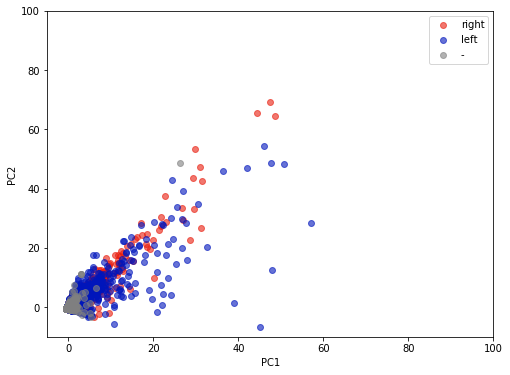

In [219]:
# plot with given labels
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
l = principal_tags_full["label"]
label_list = l.unique()
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
for target in label_list:
    target_indices = (l == target)
    ax.scatter(principal_tags_full.loc[target_indices, 'PC1']
              , principal_tags_full.loc[target_indices, 'PC2']
              , alpha=0.6, c=color_dict[target])
    ax.legend(label_list, loc='best')
    ax.set_xlim(-5,100)
    ax.set_ylim(-10,100)
    
fig.savefig("tags_pca.png", quality=95)

In [220]:
# # k-means
# kmeans = KMeans(n_clusters=2, init='k-means++', n_init=5).fit(norm_tags)


In [221]:
# clusters = pd.DataFrame(data=kmeans.labels_, columns=["label"])

In [222]:
# clusters["label"]

In [223]:
# clusters["label"].unique()

# Logistic Regression

In [224]:
# Train Logistic Regression with first 200 principal components
principal_tags_full.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,label
0,-0.465371,-0.382947,0.209452,0.073909,0.028996,0.219951,-0.107183,-0.281599,-0.064524,-0.060732,...,-0.286939,-0.156270,-0.131345,0.000871,-0.186414,0.043277,-0.099317,0.013464,0.101851,right
1,-0.388386,-0.055488,0.578863,0.148213,-0.023785,-0.003477,-0.128918,-0.207565,0.049059,-0.044912,...,0.168098,-0.138700,-0.196874,0.259532,0.091947,0.134497,0.042720,0.032934,0.063023,right
2,1.481683,-0.502096,0.089339,-0.643962,0.807387,0.170281,-0.059189,0.460610,0.051117,0.154552,...,-0.310301,0.482263,-0.540394,-0.002968,0.312855,0.534740,1.419843,0.812233,-0.465908,left
3,-0.143586,-0.059782,0.112301,0.256252,0.527842,0.698953,-0.060166,0.363188,0.120604,0.092018,...,1.315227,-1.126361,-2.665502,3.152952,0.675273,0.500347,-5.158850,-9.341757,2.289862,left
4,-0.519748,-0.516068,0.574703,0.370373,0.337382,0.293613,-0.045630,-0.087605,-0.001131,-0.053268,...,-0.145851,0.283028,0.003144,0.025340,0.067076,-0.118921,-0.000347,0.075854,-0.069618,-


In [225]:
# Remove '-' labeled data
pca_data_cleaned = principal_tags.loc[label["label"] != '-']
cleaned_labels = label.loc[label["label"] != '-']
y = cleaned_labels.label.map({"left": 1, "right": 0})

In [226]:
# split data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(StandardScaler().fit_transform(pca_data_cleaned), y, test_size=0.2, random_state=0)

In [227]:
hyperparameters_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]}
hyperparameters_lr = {"C": [1e-7,0.1e-6, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}

In [228]:
clf_grid_pca = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=hyperparameters_lr, verbose=1)

In [229]:
clf_grid_pca.fit(X_train_pca, y_train_pca)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   18.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-07, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               1, 10, 100, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [230]:
clf_pca_predictions = clf_grid_pca.predict(X_test_pca)
print("Accuracy: {}%".format(clf_grid_pca.score(X_test_pca, y_test_pca) * 100))

Accuracy: 77.01678397401191%


In [231]:
top_N_tags = get_df_n_most_frequent(norm_tags, 200)

In [232]:
top_N_cleaned = top_N_tags.loc[label["label"] != '-']

In [233]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(top_N_cleaned, y, test_size=0.2, random_state=0)

In [234]:
clf_grid_top = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=hyperparameters_lr, verbose=1)

In [235]:
clf_grid_top.fit(X_train_top, y_train_top)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-07, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               1, 10, 100, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [236]:
clf_top_predictions = clf_grid_top.predict(X_test_top)
print("Accuracy: {}%".format(clf_grid_top.score(X_test_top, y_test_top) * 100))

Accuracy: 64.45587439090417%


In [237]:
pickle.dump(clf_grid_pca, open("objects/lr_grid_pca.pickle", "wb"))

In [238]:
pickle.dump(clf_grid_top, open("objects/lr_grid_top.pickle", "wb"))

# SVM

In [239]:
clf_top = svm.SVC()

In [240]:
clf_top.fit(X_train_top, y_train_top)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [241]:
clf_top_predictions = clf_top.predict(X_test_top)
print("Accuracy: {}%".format(clf_top.score(X_test_top, y_test_top) * 100 ))

Accuracy: 63.670817541959934%


In [242]:
clf_pca = svm.SVC()

In [243]:
clf_pca.fit(X_train_pca, y_train_pca)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [244]:
clf_pca_predictions = clf_pca.predict(X_test_pca)
print("Accuracy: {}%".format(clf_pca.score(X_test_pca, y_test_pca) * 100 ))

Accuracy: 68.76015159718463%


In [245]:
pickle.dump(clf_pca, open("objects/svm_pca.pickle", "wb"))

In [246]:
pickle.dump(clf_top, open("objects/svm_top.pickle", "wb"))

# SVM-CV

In [247]:
# clf_grid_pca = GridSearchCV(svm.SVC(max_iter=1000), param_grid=hyperparameters_svm, verbose=1)

In [248]:
# clf_grid_pca.fit(X_train_pca, y_train_pca)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# label["label"].value_counts(normalize=True)


In [ ]:
# y.value_counts(normalize=True)

# KNN

In [249]:
neigh_pca = KNeighborsClassifier(n_neighbors=5)

In [250]:
neigh_pca.fit(X_train_pca, y_train_pca)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [251]:
predict_pca = neigh_pca.predict(X_test_pca)

In [252]:
accuracy_score(y_test_pca, predict_pca)

0.7655657823497564

In [253]:
neigh_top = KNeighborsClassifier(n_neighbors=5)

In [254]:
neigh_top.fit(X_train_top, y_train_top)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [255]:
predict_top = neigh_top.predict(X_test_top)

In [256]:
accuracy_score(y_test_top, predict_top)

0.6353546291283162